#GOAL

| Subtask                       | Target Variable                 | ML Type        | Evaluation Metric | Description                                               |
| ----------------------------- | ------------------------------- | -------------- | ----------------- | --------------------------------------------------------- |
|  Claim Severity Prediction    | `TotalClaims` (claims > 0 only) | Regression     | RMSE, R²          | Predict how large a claim will be (risk model)            |
|  Premium Optimization         | `CalculatedPremiumPerTerm`      | Regression     | RMSE, R²          | Predict optimized premium pricing                         |
|  Advanced                     | `ClaimOccurred`                 | Classification | Accuracy, F1, AUC | Predict claim likelihood (used to derive premium formula) |


In [5]:
# ----------------------
# claim_severity_train_notebook.py (Updated)
# ----------------------

import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------
# Load Data
# ----------------------
df = pd.read_csv("../data/processed/processed_insurance_data.csv",
                 parse_dates=["TransactionMonth", "VehicleIntroDate"])

# ----------------------
# Filter for severity (claims > 0)
# ----------------------
target_col = "TotalClaims"
df_severity = df[df[target_col] > 0].copy()

# ----------------------
# Drop low-utility / identifier / leaky columns
# ----------------------
cols_to_drop = [
    "RecordID", "UnderwrittenCoverID", "PolicyID", "TransactionMonth",
    "Title", "Bank", "AccountType", "Gender", "Country", "Province",
    "PostalCode", "MainCrestaZone", "SubCrestaZone", "ItemType", "mmcode",
    "VehicleType", "make", "Model", "bodytype", "VehicleIntroDate",
    "AlarmImmobiliser", "TrackingDevice",
    # --- Remove leaky features ---
    "CapitalOutstanding", "SumInsured", "TotalPremium"
]
df_severity.drop(columns=[c for c in cols_to_drop if c in df_severity.columns], inplace=True)

# ----------------------
# Separate features and target
# ----------------------
X = df_severity.drop(columns=[target_col])
y = df_severity[target_col]

# ----------------------
# Dynamically identify numeric and categorical columns
# ----------------------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

# Fill numeric NaNs
X[numeric_cols] = X[numeric_cols].fillna(0)

# ----------------------
# Split data
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------
# Preprocessing Pipelines
# ----------------------
linear_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# ----------------------
# Define Models
# ----------------------
models = {
    "Linear Regression": Pipeline([
        ('preprocessor', linear_preprocessor),
        ('regressor', LinearRegression())
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', tree_preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=50))
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', tree_preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=12, min_samples_leaf=30))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', tree_preprocessor),
        ('regressor', XGBRegressor(random_state=42, n_estimators=200, max_depth=6, learning_rate=0.05, verbosity=0))
    ])
}

# ----------------------
# Train and Evaluate
# ----------------------
results = []
best_model = None
best_score = float("-inf")
best_model_name = ""

print("Training and evaluating models...\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append((name, round(rmse, 2), round(r2, 3)))

    if r2 > best_score:
        best_score = r2
        best_model = model
        best_model_name = name

# ----------------------
# Save Best Model
# ----------------------
save_folder = "saved_models"
os.makedirs(save_folder, exist_ok=True)

model_filename = f"{best_model_name.lower().replace(' ', '_')}_severity_model.pkl"
model_path = os.path.join(save_folder, model_filename)
joblib.dump(best_model, model_path)

print(f"\nBest model saved to: {model_path}")
print(f"   -> Model: {best_model_name}")
print(f"   -> R² Score: {round(best_score, 3)}")

# ----------------------
# Model Comparison
# ----------------------
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²"])
print("\nModel Performance Comparison (Claim Severity):")
print(results_df.sort_values("R²", ascending=False))


Training and evaluating models...


Best model saved to: saved_models/random_forest_severity_model.pkl
   -> Model: Random Forest
   -> R² Score: 0.284

Model Performance Comparison (Claim Severity):
               Model      RMSE     R²
2      Random Forest  33798.09  0.284
1      Decision Tree  33925.88  0.279
3            XGBoost  33992.27  0.276
0  Linear Regression  35717.40  0.201


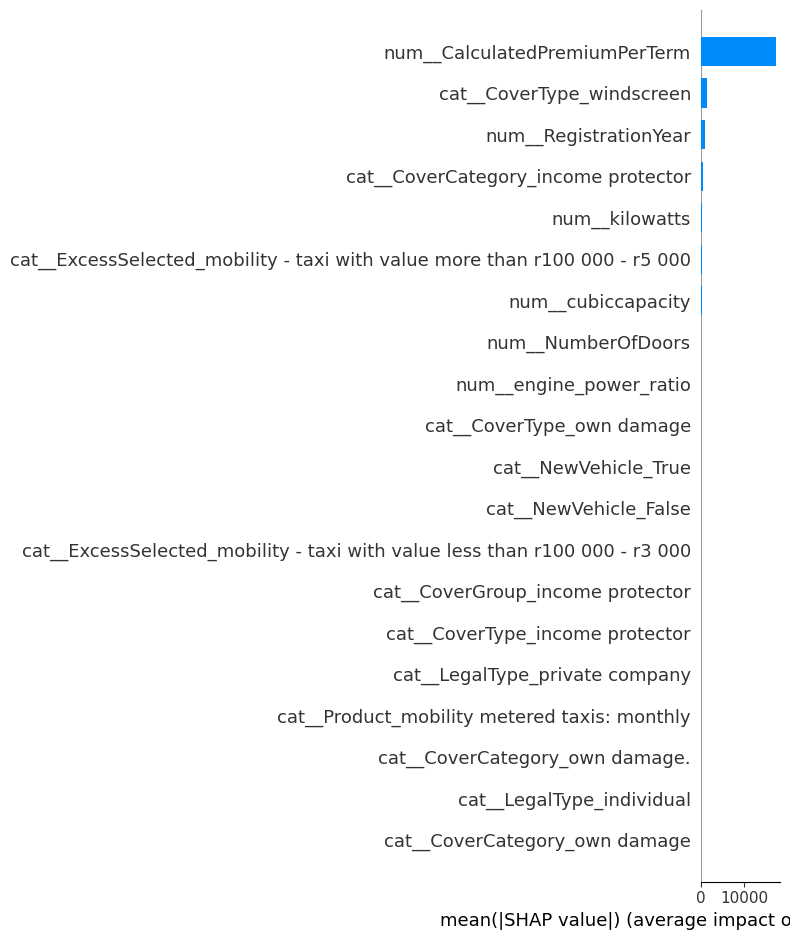

In [6]:
import joblib
import shap
import pandas as pd

# Load trained pipeline
rf_severity_pipeline = joblib.load("saved_models/random_forest_severity_model.pkl")

# Load processed dataset
df_processed = pd.read_csv("../data/processed/processed_insurance_data.csv")

# Sample for SHAP (keep all columns the pipeline expects)
X_sample = df_processed.sample(5000, random_state=42)

# Transform features using the pipeline preprocessor
X_transformed = rf_severity_pipeline.named_steps['preprocessor'].transform(X_sample)

# Extract trained estimator
rf_model = rf_severity_pipeline.named_steps['regressor']

# SHAP explainer
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_transformed)

# Summary plot
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=rf_severity_pipeline.named_steps['preprocessor'].get_feature_names_out(),
    plot_type="bar"
)


In [1]:
# ----------------------
# premium_prediction_train_fast_notebook.py
# ----------------------
import os
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------
# Setup paths
# ----------------------
DATA_PATH = "../data/processed/processed_insurance_data.csv"
MODEL_SAVE_PATH = "saved_models"
TARGET = "CalculatedPremiumPerTerm"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# ----------------------
# Load data
# ----------------------
df = pd.read_csv(DATA_PATH, parse_dates=["TransactionMonth", "VehicleIntroDate"])

# Drop leaky / identifier columns
drop_cols = [
    "RecordID", "UnderwrittenCoverID", "PolicyID",
    "TransactionMonth", "VehicleIntroDate",
    "CapitalOutstanding", "SumInsured", "TotalPremium"
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

# Features & target
X = df.drop(columns=[TARGET, "TotalClaims"], errors="ignore")
y = df[TARGET]

# Numeric & categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

# Fill numeric NaNs
X[numeric_cols] = X[numeric_cols].fillna(0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------
# Preprocessing
# ----------------------
linear_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

tree_preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# ----------------------
# Models as pipelines (fast versions)
# ----------------------
models = {
    "LinearRegression": Pipeline([
        ('preprocessor', linear_preprocessor),
        ('regressor', LinearRegression())
    ]),
    "DecisionTree": Pipeline([
        ('preprocessor', tree_preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_leaf=20))
    ]),
    "RandomForest": Pipeline([
        ('preprocessor', tree_preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_estimators=50, max_depth=12, min_samples_leaf=30))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', tree_preprocessor),
        ('regressor', XGBRegressor(
            random_state=42,
            n_estimators=50,           # reduced for fast training
            max_depth=6,
            learning_rate=0.05,
            verbosity=0,
            enable_categorical=False
        ))
    ])
}

# ----------------------
# Train & Evaluate
# ----------------------
results = []
best_r2 = -np.inf
best_model = None
best_model_name = ""

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "RMSE": round(rmse, 2), "R2 Score": round(r2, 3)})
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_model_name = name

# ----------------------
# Save best model
# ----------------------
if best_model:
    save_path = os.path.join(MODEL_SAVE_PATH, f"{best_model_name.lower()}_premium_model_fast.pkl")
    joblib.dump(best_model, save_path)
    print(f"\nBest model '{best_model_name}' saved to: {save_path}")

# Display results
results_df = pd.DataFrame(results).sort_values("R2 Score", ascending=False)
print("\nModel Performance (Premium Prediction - Fast Version):")
print(results_df)


Training LinearRegression...
Training DecisionTree...
Training RandomForest...
Training XGBoost...

Best model 'RandomForest' saved to: saved_models/randomforest_premium_model_fast.pkl

Model Performance (Premium Prediction - Fast Version):
              Model          RMSE      R2 Score
2      RandomForest  3.311000e+01  9.770000e-01
1      DecisionTree  3.866000e+01  9.690000e-01
3           XGBoost  4.317000e+01  9.610000e-01
0  LinearRegression  3.097059e+10 -1.989512e+16


In [2]:

#
# Load trained pipeline
xgboost_premium = joblib.load("saved_models/randomforest_premium_model_fast.pkl")
import shap
#best_model = models["xgboost_m"]
explainer = shap.TreeExplainer(xgboost_premium)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):  # multiclass
    shap.summary_plot(shap_values[1], X_test)
else:
    shap.summary_plot(shap_values, X_test)


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

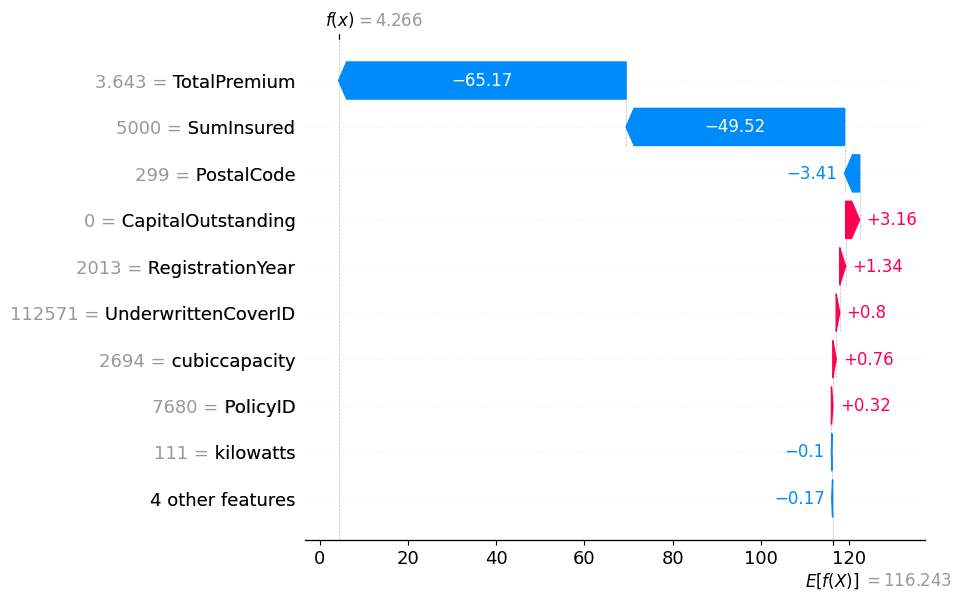

In [64]:
# For the first test sample
sample_idx = 10

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=X_test.columns
    )
)


# Predicting Claim Probability
#Goal:
#Build a classification model to predict the probability that a customer will file a claim.
this model helps to build a risk-adjusted premiumu uisng 
Risk-Based Premium = P(claim) × E(claim amount) + Expenses + Profit Margin


In [ ]:
# ----------------------
# claim_probability_train_safe_sparse.py
# ----------------------
import os
import time
import joblib
import warnings
import pandas as pd
import numpy as np
from collections import Counter

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve

from imblearn.over_sampling import SMOTE
from scipy import sparse
import sklearn

# ----------------------
# Config
# ----------------------
DATA_PATH = "../data/processed/processed_insurance_data.csv"
MODEL_SAVE_PATH = "saved_models"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

RANDOM_STATE = 42
SAMPLE_FRAC = 0.2     # subsample for stability (increase later)
TOP_K = 15            # top categories for high-cardinality categorical features

print("Using scikit-learn version:", sklearn.__version__)
print("Config:", DATA_PATH, "sample_frac=", SAMPLE_FRAC, "top_k=", TOP_K)

# ----------------------
# Load data
# ----------------------
start_all = time.time()
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Original shape:", df.shape)

if 0 < SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)
    print("Subsampled shape:", df.shape)

# ----------------------
# Create target and drop leaky/id columns
# ----------------------
df['ClaimOccurred'] = (df.get('TotalClaims', 0) > 0).astype(int)

drop_cols = [
    "RecordID", "UnderwrittenCoverID", "PolicyID",
    "TransactionMonth", "VehicleIntroDate",
    "CalculatedPremiumPerTerm", "TotalPremium",
    "SumInsured", "CapitalOutstanding"
]
present_drop = [c for c in drop_cols if c in df.columns]
df.drop(columns=present_drop, inplace=True)

TARGET = 'ClaimOccurred'
y = df[TARGET]
X = df.drop(columns=[TARGET, 'TotalClaims'] if 'TotalClaims' in df.columns else [TARGET])

# ----------------------
# Features: numeric & categorical
# ----------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

def reduce_cardinality(df, cols, top_k=15):
    df = df.copy()
    for c in cols:
        top = df[c].value_counts().index[:top_k]
        df[c] = df[c].where(df[c].isin(top), other="__OTHER__")
    return df

# ----------------------
# Encode categorical features as sparse
# ----------------------
if cat_cols:
    X_cat = reduce_cardinality(X[cat_cols].fillna("__NA__").astype(str), cat_cols, TOP_K)
    # version-compatible OHE
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
    X_cat_sparse = ohe.fit_transform(X_cat)
else:
    X_cat_sparse = None
    ohe = None

# numeric features
X_num = X[num_cols].fillna(0).astype(float)
X_num_sparse = sparse.csr_matrix(X_num)

# combine numeric + categorical sparse
if X_cat_sparse is not None:
    X_full = sparse.hstack([X_num_sparse, X_cat_sparse]).tocsr()
else:
    X_full = X_num_sparse

print("Final feature shape (sparse):", X_full.shape)

# ----------------------
# Train/test split
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# ----------------------
# SMOTE resampling
# ----------------------
print("Applying SMOTE...")
smote = SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)  # moderate oversampling
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", X_train_res.shape, "Positive rate:", y_train_res.mean())

# ----------------------
# Scaling numeric features
# ----------------------
scaler = StandardScaler(with_mean=False)  # works with sparse
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------------
# Define models
# ----------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight='balanced', random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(max_depth=8, class_weight='balanced', random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                             eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE, n_jobs=2)
}

# ----------------------
# Train & Evaluate
# ----------------------
results = []
best_auc, best_model, best_name = -1, None, None

for name, clf in models.items():
    print(f"\nTraining {name} ...")
    t0 = time.time()
    clf.fit(X_train_scaled, y_train_res)
    train_time = time.time() - t0

    y_proba = clf.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    # find best threshold
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if thresholds.size > 0 else 0.5
    best_f1 = f1_scores[best_idx] if thresholds.size > 0 else 0.0

    report = classification_report(y_test, (y_proba >= best_threshold).astype(int), zero_division=0, output_dict=True)

    results.append({
        "Model": name,
        "ROC_AUC": round(float(auc), 4),
        "Best_Threshold": round(float(best_threshold), 4),
        "Best_F1": round(float(best_f1), 4),
        "Accuracy": round(report.get("accuracy", 0), 4),
        "Recall_1": round(report.get("1", {}).get("recall", 0), 4),
        "F1_1": round(report.get("1", {}).get("f1-score", 0), 4),
        "TrainTime_s": round(train_time, 1)
    })

    if auc > best_auc:
        best_auc, best_model, best_name = auc, clf, name

# ----------------------
# Show results
# ----------------------
results_df = pd.DataFrame(results).sort_values("ROC_AUC", ascending=False)
print("\nSummary of Model Performance:")
print(results_df)

# ----------------------
# Save best model + scaler + OHE
# ----------------------
if best_model is not None:
    joblib.dump(best_model, os.path.join(MODEL_SAVE_PATH, f"{best_name.lower()}_claim_model.pkl"))
    joblib.dump(scaler, os.path.join(MODEL_SAVE_PATH, "scaler_claim.pkl"))
    if ohe is not None:
        joblib.dump(ohe, os.path.join(MODEL_SAVE_PATH, "ohe_claim.pkl"))

print(f"\nBest model: {best_name} (ROC_AUC={best_auc:.4f})")
print("Total elapsed time: {:.1f}s".format(time.time() - start_all))


Loading dataset...
Original shape: (998443, 56)
Dropped columns: ['RecordID', 'UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'VehicleIntroDate', 'CalculatedPremiumPerTerm', 'TotalPremium', 'SumInsured', 'CapitalOutstanding']


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

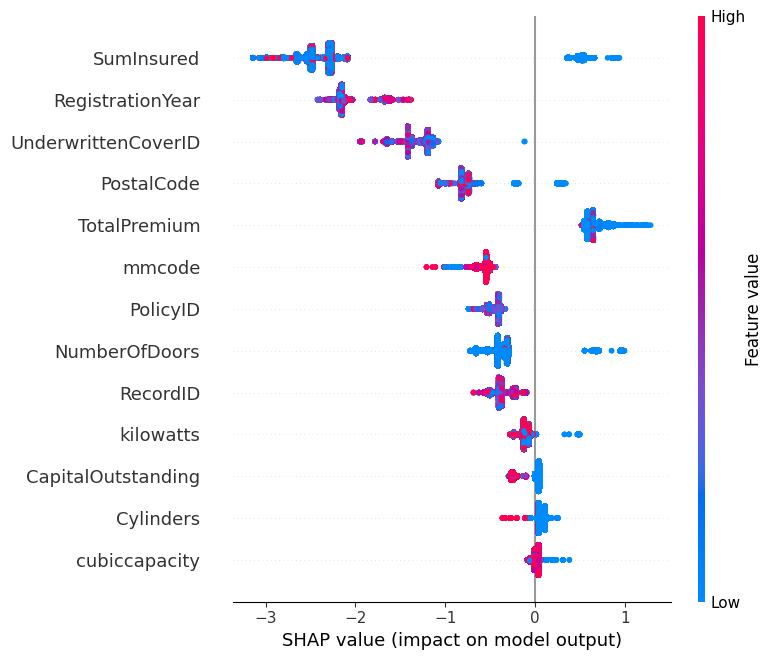

In [61]:
# Load trained pipeline
xgboost_claim = joblib.load("saved_models/xgboost_claim_model.pkl")
import shap
#best_model = models["xgboost_m"]
explainer = shap.TreeExplainer(xgboost_claim)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):  # multiclass
    shap.summary_plot(shap_values[1], X_test)
else:
    shap.summary_plot(shap_values, X_test)


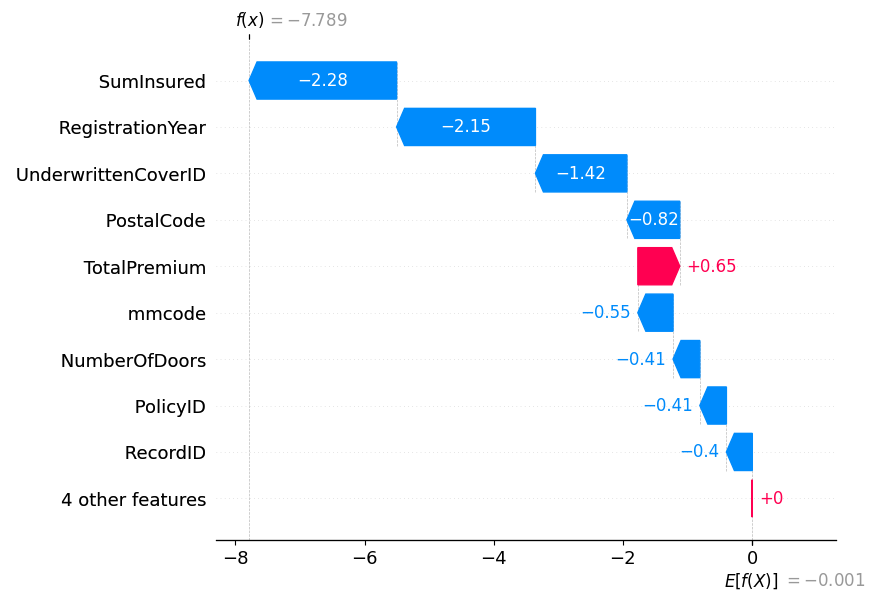

In [59]:
idx = 10
# If shap_values is a list (for multiclass)
if isinstance(shap_values, list):
    shap_value = shap_values[1][idx]
else:
    shap_value = shap_values[idx]
# Plot waterfall
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_value, X_test.iloc[idx])

In [3]:
import joblib

# Load all three models
severity_model = joblib.load("saved_models/xgboost_premium_model.pkl")
premium_model = joblib.load("saved_models/random_forest_severity_model.pkl")
claim_model = joblib.load("saved_models/xgboost_claim_model.pkl")
scaler = joblib.load("saved_models/scaler.pkl")
# Extract and print feature names used during model training
print("Severity Model Features:")
print(severity_model.feature_names_in_)

print("\nPremium Model Features:")
print(premium_model.feature_names_in_)
print("\nclaim probablity:")
print(claim_model.get_booster().feature_names)  
print(scaler.feature_names_in_)  

Severity Model Features:
['RecordID' 'UnderwrittenCoverID' 'PolicyID' 'PostalCode' 'mmcode'
 'RegistrationYear' 'Cylinders' 'cubiccapacity' 'kilowatts'
 'NumberOfDoors' 'CapitalOutstanding' 'SumInsured' 'TotalPremium']

Premium Model Features:
['IsVATRegistered' 'LegalType' 'RegistrationYear' 'Cylinders'
 'cubiccapacity' 'kilowatts' 'NumberOfDoors' 'CapitalOutstanding'
 'NewVehicle' 'WrittenOff' 'Rebuilt' 'Converted' 'SumInsured'
 'TermFrequency' 'CalculatedPremiumPerTerm' 'ExcessSelected'
 'CoverCategory' 'CoverType' 'CoverGroup' 'Section' 'Product'
 'StatutoryClass' 'StatutoryRiskType' 'TotalPremium' 'transaction_date'
 'vehicle_age' 'vehicle_age_at_transaction' 'engine_power_ratio'
 'is_high_power_vehicle' 'term_frequency_encoded' 'transaction_year'
 'transaction_month_num' 'policy_age']

claim probablity:
None
['RecordID' 'UnderwrittenCoverID' 'PolicyID' 'PostalCode' 'mmcode'
 'RegistrationYear' 'Cylinders' 'cubiccapacity' 'kilowatts'
 'NumberOfDoors' 'CapitalOutstanding' 'SumInsur